## Imports and removing hetatms

In [2]:
from itertools import chain
import numpy as np
from Bio.PDB import *
import os
import warnings
import matplotlib.pyplot as plt
import random
amino3CodesStr = 'alaargasnaspcysgluglnglyhisileleulysmetpheproserthrtrptyrval'
amino3Codes = [amino3CodesStr[x:x+3].upper() for x in range(0, len(amino3CodesStr), 3)]
amino3Codes = list(sorted(amino3Codes))
print(amino3Codes, len(amino3Codes)) 
os.makedirs("cleanGeneral")
for filename in os.listdir("generalData/PDBStr"):
    allProteins = open("generalData/PDBStr/"+filename, 'r')
    onlyATMs = open('cleanGeneral/'+filename, 'w')
    for line in allProteins:
        if (line[0:6] != "HETATM"):
            onlyATMs.write(line)
    allProteins.close()
    onlyATMs.close()

['ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 'GLY', 'HIS', 'ILE', 'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL'] 20


## Count fraction of repeating and Count interactions

In [3]:
with open("generalData\pdb_4960list.txt", "r") as f:
    i = 0
    counter = 0
    for l in f.readlines():
        counter+=1
        lineList = l.strip().split()
        pdbName = lineList[1] + '.pdb'
        chainNames = [lineList[2], lineList[5]]
        if chainNames[0] == chainNames[1]:
            i+=1
    print(i, counter)

919 4144


<>:1: SyntaxWarning: invalid escape sequence '\p'
<>:1: SyntaxWarning: invalid escape sequence '\p'
C:\Users\Tom\AppData\Local\Temp\ipykernel_16892\1483185826.py:1: SyntaxWarning: invalid escape sequence '\p'
  with open("generalData\pdb_4960list.txt", "r") as f:


In [6]:
os.makedirs("generalMatchData")
parser = PDBParser()
errorPDBNames = []
with open("generalData\pdb_4960list.txt", "r") as f:
    for l in f.readlines():
        lineList = l.strip().split()
        pdbName = lineList[1] + '.pdb'
        chainNames = [lineList[2], lineList[5]]
        if chainNames[0] != chainNames[1]:
            # add to the official list
            protein = parser.get_structure(pdbName[:-4], "cleanGeneral/"+pdbName)
            chains = list(list(protein.get_models())[0].get_chains())
            chainL, chainH = [], []
            for x in chains:
                if x.id == chainNames[0]:
                    chainL = list(x.get_residues())
                if x.id == chainNames[1]:
                    chainH = list(x.get_residues())
            resA, resB = chainL, chainH
            AAtomList = list(chain.from_iterable([list(x.get_atoms()) for x in resA if x.get_resname() in amino3Codes])) 
            BAtomList = list(chain.from_iterable([list(x.get_atoms()) for x in resB if x.get_resname() in amino3Codes]))
            
            if len(BAtomList) == 0 or len(AAtomList)==0:
                errorPDBNames.append(pdbName)
                continue
            NBSearch, NBSearch3 = NeighborSearch(AAtomList), NeighborSearch(BAtomList)
            InteractingAList = []
            for res in resB:
                for atm in list(res.get_atoms()):
                    centerPos = atm.coord
                    if len(NBSearch.search(centerPos, 5, 'R')) > 0:
                        InteractingAList.append(res)
                        break
            InteractingBList = []
            for res in resA:
                for atm in list(res.get_atoms()):
                    centerPos = atm.coord
                    if len(NBSearch3.search(centerPos, 5, 'R')) > 0:
                        InteractingBList.append(res)
                        break

            AInteractionList, BInteractionList = {}, {}
            for i in range(len(amino3Codes)):
                for j in range(i, len(amino3Codes)):
                    combinationName = amino3Codes[i] + " " + amino3Codes[j]
                    AInteractionList[combinationName] = 0
                    BInteractionList[combinationName] = 0
            ### Count intra-Ag interactions -> dict
            atms = [r.get_atoms() for r in InteractingAList if r.get_resname() in amino3Codes]
            NBSearch2 = NeighborSearch(list(chain.from_iterable(atms))) # Count interactions using neighbor search
            AInteractions = NBSearch2.search_all(5, level='R')
            for (r1, r2) in AInteractions:
                combinationName = min([r1.get_resname(), r2.get_resname()]) + " " + max([r1.get_resname(), r2.get_resname()])
                AInteractionList[combinationName] += 1
            
            atms = [r.get_atoms() for r in InteractingBList if r.get_resname() in amino3Codes]
            NBSearch2 = NeighborSearch(list(chain.from_iterable(atms))) # Count interactions using neighbor search
            BInteractions = NBSearch2.search_all(5, level='R')
            for (r1, r2) in BInteractions:
                combinationName = min([r1.get_resname(), r2.get_resname()]) + " " + max([r1.get_resname(), r2.get_resname()])
                BInteractionList[combinationName] += 1

            ### Save dict as normalized chart numpy 2d array
            # Create frequency chart/triangle using the alphabetized amino codes
            AfreqChart = np.empty((20, 20))
            AfreqChart.fill(np.nan)
            for r in range(len(amino3Codes)):
                for c in range(r, len(amino3Codes)):
                    fst, snd = amino3Codes[r], amino3Codes[c]
                    combinationName = fst + " " + snd
                    count = AInteractionList[combinationName]
                    AfreqChart[r, c] = count
            BfreqChart = np.empty((20, 20))
            BfreqChart.fill(np.nan)
            for r in range(len(amino3Codes)):
                for c in range(r, len(amino3Codes)):
                    fst, snd = amino3Codes[r], amino3Codes[c]
                    combinationName = fst + " " + snd
                    count = BInteractionList[combinationName]
                    BfreqChart[r, c] = count
            # Normalize
            AfreqChart -= np.nanmin(AfreqChart)
            BfreqChart -= np.nanmin(BfreqChart)
            with warnings.catch_warnings():
                warnings.filterwarnings('error')
                try:
                    AfreqChart /= (np.nanmax(AfreqChart) - np.nanmin(AfreqChart))
                    BfreqChart /= (np.nanmax(BfreqChart) - np.nanmin(BfreqChart))
                except:
                    errorPDBNames.append(pdbName)
                    continue

            ### Make matches
            flippedAb = np.flip(AfreqChart)
            matchFreqChart = np.concatenate([flippedAb, BfreqChart], axis=1)
            with warnings.catch_warnings():
                warnings.filterwarnings('error')
                try:
                    matchFreqChart = np.array([r[~np.isnan(r)] for r in matchFreqChart])
                except:
                    errorPDBNames.append(pdbName)
                    continue
            
            with open("generalMatchData/"+pdbName[:-4]+".npy", "wb") as f:
                np.save(f, matchFreqChart)

<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:4: SyntaxWarning: invalid escape sequence '\p'
C:\Users\Tom\AppData\Local\Temp\ipykernel_16892\316939510.py:4: SyntaxWarning: invalid escape sequence '\p'
  with open("generalData\pdb_4960list.txt", "r") as f:
C:\Users\Tom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\Bio\PDB\Atom.py:232: PDBConstructionWarning: Could not assign element 'X' for Atom (name=XE1) with given element 'X'
  warnings.warn(msg, PDBConstructionWarning)
C:\Users\Tom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\Bio\PDB\Atom.py:232: PDBConstructionWarning: Could not assign element 'X' for Atom (name=XE2) with given element 'X'
  warnings.warn(msg, PDBConstructionWarning)


In [7]:
print(len(errorPDBNames), errorPDBNames)

7 ['1gu8.pdb', '2vo1.pdb', '1cm4.pdb', '1pci.pdb', '1cjl.pdb', '2cse.pdb', '1lhg.pdb']


In [8]:
len(os.listdir("generalMatchData"))

3218

In [9]:
matchingArr = []
for filename in os.listdir("matchData"):
    matchingArr.append(np.load("matchData/"+filename))
mismatchArr = []
for filename in os.listdir("generalMatchData"):
    mismatchArr.append(np.load("generalMatchData/"+filename))

data, labels = [], []
for arr in matchingArr:
    data.append(arr)
    labels.append(1)
for arr in mismatchArr:
    data.append(arr)
    labels.append(0)
data = np.array(data)
labels = np.array(labels).reshape(-1, 1)
print(labels[0])

[1]


In [10]:
len(matchingArr)

1215

Plotting examples (note: 1214/1215 is the index border between the Ab/Ag matches and general proteins)

[0]


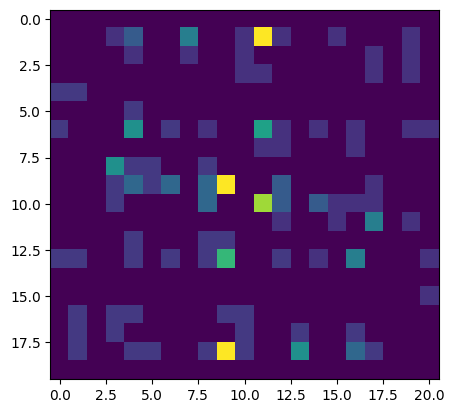

In [13]:
plt.imshow(data[1216])
print(labels[1216])

Plotting examples of matching pairs

Text(0.5, 0.98, 'Example Matching Combined Residue Interaction Relative Frequencies of Ab/Ag Dataset')

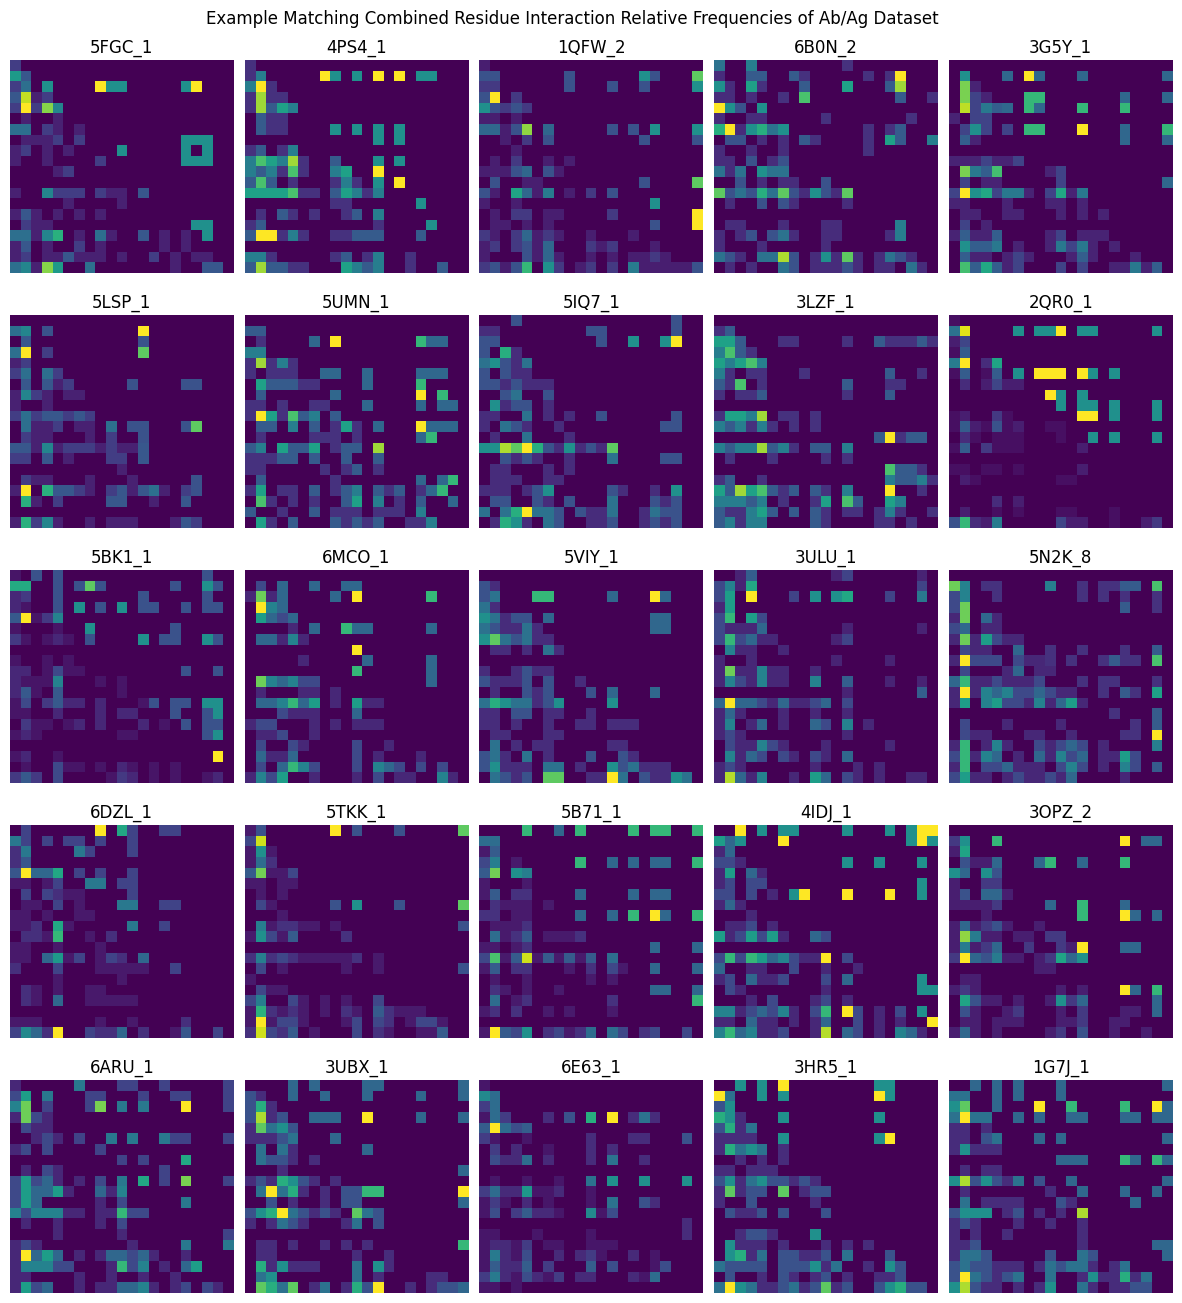

In [14]:
sampleRange1 = random.sample(range(len(matchingArr)), 25)
randomMatches = data[sampleRange1]
mapNames = [os.listdir("matchData")[x] for x in sampleRange1]
mapNames = [x[9:-4] for x in mapNames]
k=5
fig, axes = plt.subplots(k, k, figsize=(15, 15))
for i in range(k):
    for j in range(k):
        axes[i, j].axis("off")
        axes[i, j].imshow(randomMatches[i*5+j])
        axes[i, j].set_title(mapNames[i*5+j])
plt.subplots_adjust(top=0.96, wspace=0.05, hspace=0)
fig.suptitle("Example Matching Combined Residue Interaction Relative Frequencies of Ab/Ag Dataset")

Plotting general protein pairs

Text(0.5, 0.98, 'Example Nonmatching Combined Residue Interaction Relative Frequency of Ab/Ag Dataset')

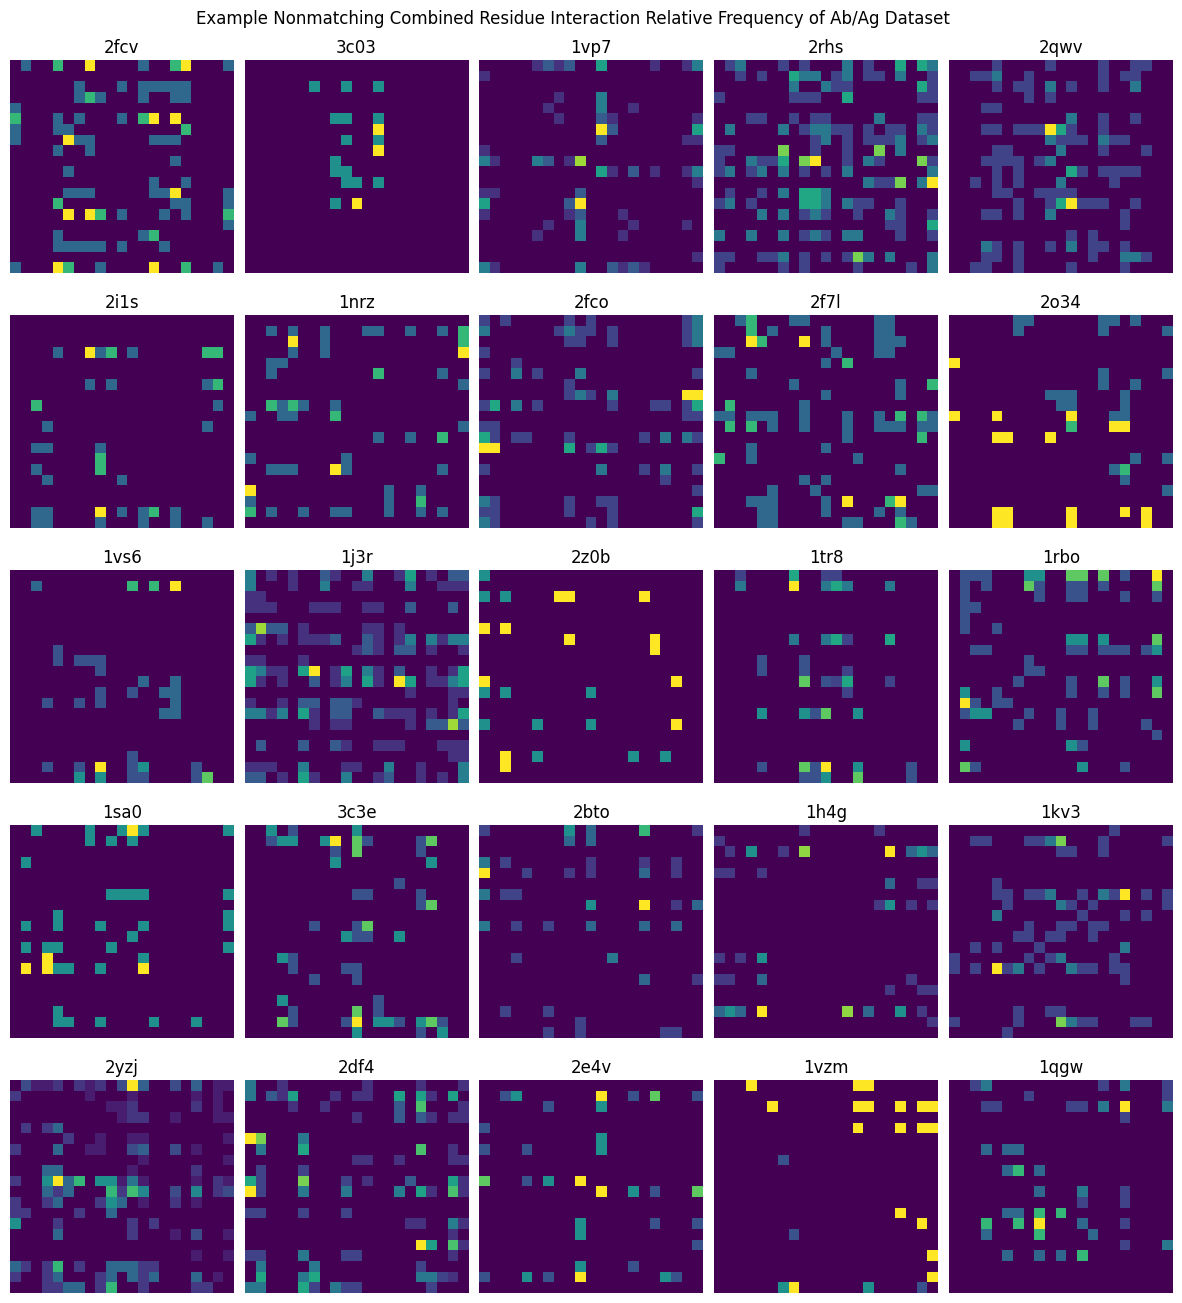

In [15]:
sampleRange2 = random.sample(range(len(matchingArr), len(data)), 25)
randomMatches = data[sampleRange2]
mapNames = [os.listdir("generalMatchData")[x-len(matchingArr)] for x in sampleRange2]
mapNames = [x[:-4] for x in mapNames]
k=5
fig, axes = plt.subplots(k, k, figsize=(15, 15))
for i in range(k):
    for j in range(k):
        axes[i, j].axis("off")
        axes[i, j].imshow(randomMatches[i*5+j])
        axes[i, j].set_title(mapNames[i*5+j])
plt.subplots_adjust(top=0.96, wspace=0.05, hspace=0)
fig.suptitle("Example Nonmatching Combined Residue Interaction Relative Frequency of Ab/Ag Dataset")

## CNN for classification

### Function to create the model

In [16]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Input, Dropout
from keras import applications
def create_model():
    # base_model=applications.VGG16(include_top=False, weights='imagenet',input_tensor=Input(shape=(20, 21, 1)))
    # for layer in base_model.layers:
    #     layer.trainable = False
    model = Sequential()
    model.add(Conv2D(64, kernel_size=3, padding='same', activation='relu', input_shape=(20,21,1)))
    model.add(MaxPooling2D((2, 2), padding='same'))
    #model.add(Dropout(0.25))

    model.add(Conv2D(64, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D((2, 2), padding='same'))
    #model.add(Dropout(0.25))

    model.add(Conv2D(64, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D((2, 2), padding='same'))

    model.add(Flatten())

    model.add(Dense(512, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

### Training and Testing and 10-fold CV

In [12]:
def plot_roc_curve(fpr,tpr):
    fig = plt.figure(figsize=(15, 15)) 
    plt.plot(fpr,tpr, linewidth=6.0) 
    plt.axis([0,1,0,1]) 
    plt.title("ROC Curve for Ab/Ag and General Combined Internal Residue Combination Frequency Chart Prediction")
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate') 
    plt.show()    

Epoch 1/1000


C:\Users\Tom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


285/285 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6211 - loss: 0.6657 - precision: 0.2589 - recall: 0.2306 - val_accuracy: 0.7252 - val_loss: 0.5704 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/1000
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7293 - loss: 0.5542 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.7252 - val_loss: 0.4969 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/1000
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7431 - loss: 0.4771 - precision: 0.8225 - recall: 0.0701 - val_accuracy: 0.8739 - val_loss: 0.3379 - val_precision: 0.9459 - val_recall: 0.5738
Epoch 4/1000
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8945 - loss: 0.3197 - precision: 0.9337 - recall: 0.6786 - val_accuracy: 0.9595 - val_loss: 0.1958 - val_precision: 0.9483 - val_recall: 0.9016
Epoch 5/1000
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9453 - loss: 0.1952 - precision: 0.9258 - recall: 0.8738 - val_accuracy: 

C:\Users\Tom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


285/285 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5855 - loss: 0.6697 - precision_1: 0.3020 - recall_1: 0.3872 - val_accuracy: 0.7252 - val_loss: 0.5746 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 2/1000
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7185 - loss: 0.5648 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_accuracy: 0.7252 - val_loss: 0.5101 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 3/1000
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7333 - loss: 0.4800 - precision_1: 0.6606 - recall_1: 0.0510 - val_accuracy: 0.9099 - val_loss: 0.3413 - val_precision_1: 0.9881 - val_recall_1: 0.6803
Epoch 4/1000
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9125 - loss: 0.2967 - precision_1: 0.9660 - recall_1: 0.7032 - val_accuracy: 0.9707 - val_loss: 0.1802 - val_precision_1: 0.9658 - val_recall_1: 0.9262
Epoch 5/1000
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9682 - loss: 0.1625 - precision_1: 0.9576

C:\Users\Tom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


285/285 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7313 - loss: 0.6519 - precision_2: 0.1628 - recall_2: 0.0035 - val_accuracy: 0.7252 - val_loss: 0.5684 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 2/1000
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7170 - loss: 0.5696 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_accuracy: 0.7252 - val_loss: 0.5117 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 3/1000
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7352 - loss: 0.4879 - precision_2: 0.5618 - recall_2: 0.0246 - val_accuracy: 0.8423 - val_loss: 0.3623 - val_precision_2: 0.9815 - val_recall_2: 0.4344
Epoch 4/1000
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8833 - loss: 0.3179 - precision_2: 0.9425 - recall_2: 0.5820 - val_accuracy: 0.9527 - val_loss: 0.2060 - val_precision_2: 0.9316 - val_recall_2: 0.8934
Epoch 5/1000
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9491 - loss: 0.1907 - precision_2: 0.9303

C:\Users\Tom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


285/285 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6406 - loss: 0.6655 - precision_3: 0.3850 - recall_3: 0.3528 - val_accuracy: 0.7246 - val_loss: 0.5701 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 2/1000
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7382 - loss: 0.5433 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - val_accuracy: 0.7246 - val_loss: 0.5010 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 3/1000
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7363 - loss: 0.4645 - precision_3: 0.8396 - recall_3: 0.0508 - val_accuracy: 0.9052 - val_loss: 0.3352 - val_precision_3: 0.9651 - val_recall_3: 0.6803
Epoch 4/1000
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9318 - loss: 0.2855 - precision_3: 0.9605 - recall_3: 0.7809 - val_accuracy: 0.9481 - val_loss: 0.1910 - val_precision_3: 0.9231 - val_recall_3: 0.8852
Epoch 5/1000
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9512 - loss: 0.1765 - precision_3: 0.9320

C:\Users\Tom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


285/285 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6983 - loss: 0.6587 - precision_4: 0.3542 - recall_4: 0.1036 - val_accuracy: 0.7246 - val_loss: 0.5691 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00
Epoch 2/1000
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7377 - loss: 0.5479 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - val_accuracy: 0.7246 - val_loss: 0.5020 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00
Epoch 3/1000
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7377 - loss: 0.4651 - precision_4: 0.7426 - recall_4: 0.0458 - val_accuracy: 0.8488 - val_loss: 0.3444 - val_precision_4: 0.9825 - val_recall_4: 0.4590
Epoch 4/1000
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9158 - loss: 0.2917 - precision_4: 0.9689 - recall_4: 0.7255 - val_accuracy: 0.9458 - val_loss: 0.1990 - val_precision_4: 0.9804 - val_recall_4: 0.8197
Epoch 5/1000
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9670 - loss: 0.1610 - precision_4: 0.9528

C:\Users\Tom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


285/285 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6977 - loss: 0.6591 - precision_5: 0.2452 - recall_5: 0.0630 - val_accuracy: 0.7269 - val_loss: 0.5736 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00
Epoch 2/1000
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7129 - loss: 0.5672 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - val_accuracy: 0.7269 - val_loss: 0.5134 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00
Epoch 3/1000
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7356 - loss: 0.4729 - precision_5: 0.6904 - recall_5: 0.0277 - val_accuracy: 0.8600 - val_loss: 0.3514 - val_precision_5: 0.9836 - val_recall_5: 0.4959
Epoch 4/1000
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9077 - loss: 0.3033 - precision_5: 0.9801 - recall_5: 0.6739 - val_accuracy: 0.9571 - val_loss: 0.1986 - val_precision_5: 0.9397 - val_recall_5: 0.9008
Epoch 5/1000
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9640 - loss: 0.1719 - precision_5: 0.9575

C:\Users\Tom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


285/285 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6454 - loss: 0.6656 - precision_6: 0.3030 - recall_6: 0.2191 - val_accuracy: 0.7269 - val_loss: 0.5717 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00
Epoch 2/1000
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7235 - loss: 0.5655 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - val_accuracy: 0.7269 - val_loss: 0.5245 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00
Epoch 3/1000
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7249 - loss: 0.5053 - precision_6: 0.4408 - recall_6: 0.0077 - val_accuracy: 0.8014 - val_loss: 0.3967 - val_precision_6: 1.0000 - val_recall_6: 0.2727
Epoch 4/1000
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8671 - loss: 0.3476 - precision_6: 0.9686 - recall_6: 0.5385 - val_accuracy: 0.9413 - val_loss: 0.2183 - val_precision_6: 0.9439 - val_recall_6: 0.8347
Epoch 5/1000
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9551 - loss: 0.1922 - precision_6: 0.9452

C:\Users\Tom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


285/285 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6991 - loss: 0.6604 - precision_7: 0.2944 - recall_7: 0.0866 - val_accuracy: 0.7269 - val_loss: 0.5788 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00
Epoch 2/1000
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7299 - loss: 0.5594 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00 - val_accuracy: 0.7269 - val_loss: 0.5210 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00
Epoch 3/1000
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7377 - loss: 0.4825 - precision_7: 0.6127 - recall_7: 0.0344 - val_accuracy: 0.8939 - val_loss: 0.3568 - val_precision_7: 0.9512 - val_recall_7: 0.6446
Epoch 4/1000
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8988 - loss: 0.3115 - precision_7: 0.9570 - recall_7: 0.6755 - val_accuracy: 0.9413 - val_loss: 0.2047 - val_precision_7: 0.9130 - val_recall_7: 0.8678
Epoch 5/1000
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9565 - loss: 0.1713 - precision_7: 0.9319

C:\Users\Tom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


285/285 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7189 - loss: 0.6553 - precision_8: 0.4217 - recall_8: 0.0812 - val_accuracy: 0.7269 - val_loss: 0.5618 - val_precision_8: 0.0000e+00 - val_recall_8: 0.0000e+00
Epoch 2/1000
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7192 - loss: 0.5497 - precision_8: 0.0000e+00 - recall_8: 0.0000e+00 - val_accuracy: 0.7269 - val_loss: 0.4801 - val_precision_8: 0.0000e+00 - val_recall_8: 0.0000e+00
Epoch 3/1000
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7571 - loss: 0.4439 - precision_8: 0.8327 - recall_8: 0.1249 - val_accuracy: 0.9300 - val_loss: 0.3027 - val_precision_8: 0.9500 - val_recall_8: 0.7851
Epoch 4/1000
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9372 - loss: 0.2647 - precision_8: 0.9528 - recall_8: 0.8076 - val_accuracy: 0.9436 - val_loss: 0.1822 - val_precision_8: 0.9068 - val_recall_8: 0.8843
Epoch 5/1000
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9568 - loss: 0.1637 - precision_8: 0.9363

C:\Users\Tom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


285/285 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7316 - loss: 0.6483 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - val_accuracy: 0.7269 - val_loss: 0.5602 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 2/1000
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7218 - loss: 0.5512 - precision_9: 0.2622 - recall_9: 7.4188e-04 - val_accuracy: 0.7404 - val_loss: 0.4631 - val_precision_9: 1.0000 - val_recall_9: 0.0496
Epoch 3/1000
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7912 - loss: 0.4219 - precision_9: 0.9735 - recall_9: 0.2707 - val_accuracy: 0.9074 - val_loss: 0.2853 - val_precision_9: 0.9444 - val_recall_9: 0.7025
Epoch 4/1000
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9340 - loss: 0.2483 - precision_9: 0.9556 - recall_9: 0.8065 - val_accuracy: 0.9526 - val_loss: 0.1764 - val_precision_9: 0.9237 - val_recall_9: 0.9008
Epoch 5/1000
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9600 - loss: 0.1534 - precision_9: 0.9442 - r

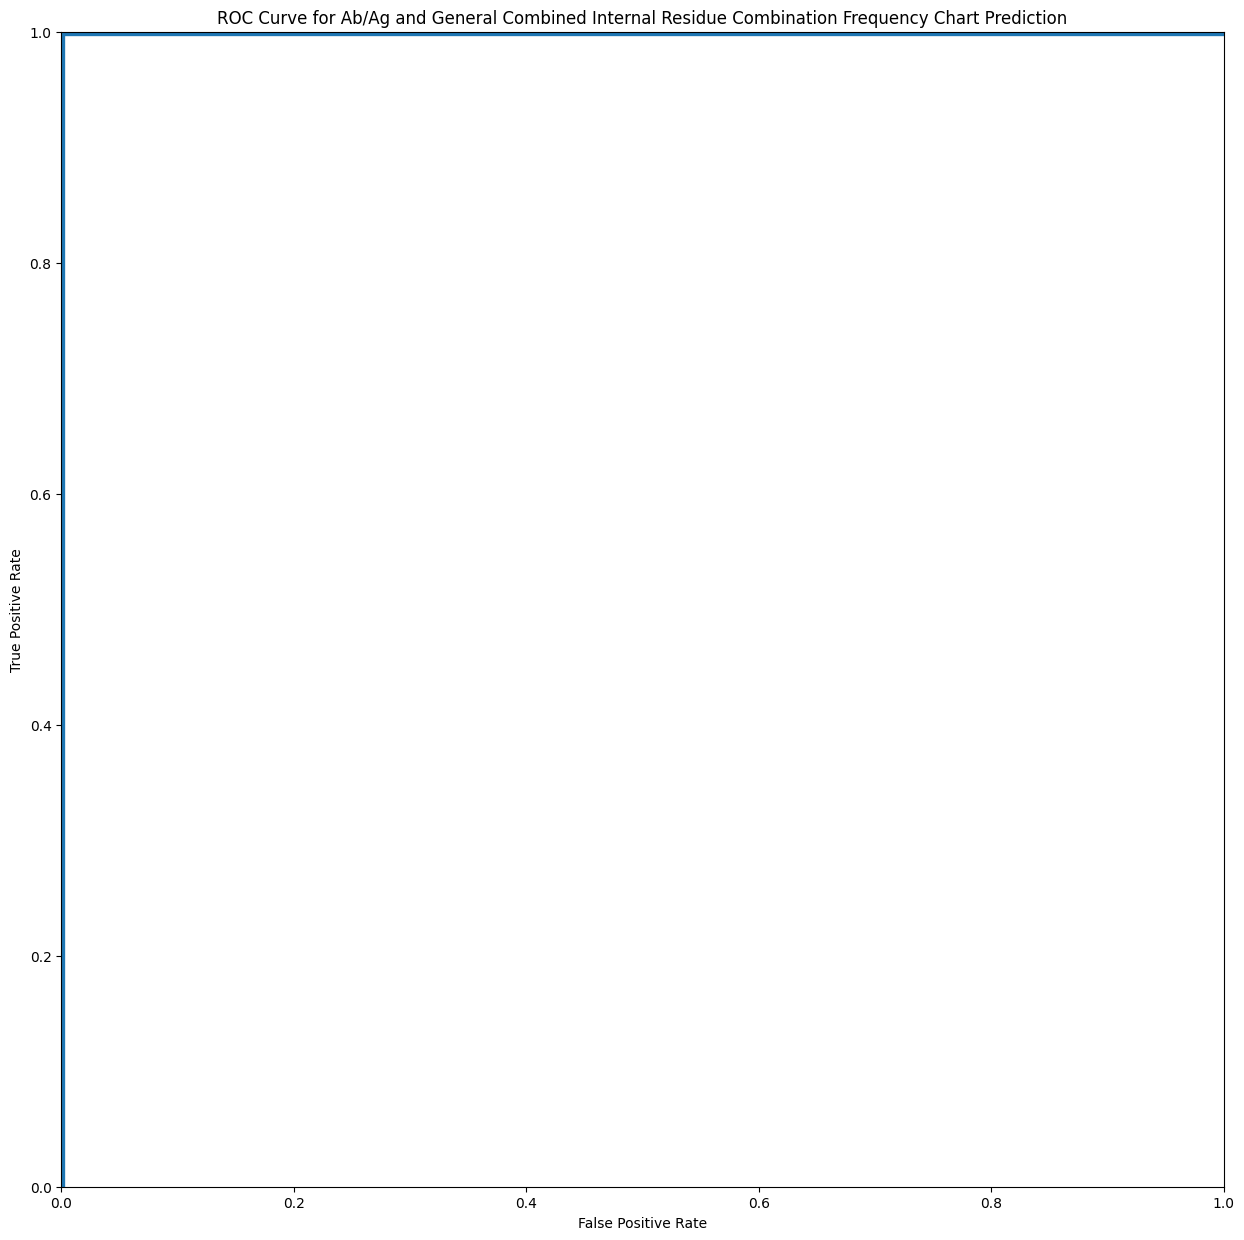

1.0
[0.99796992 0.01497029 0.99986679 0.99672098 0.99588132 0.99628938]
[0.00235561 0.00738114 0.00023175 0.00541759 0.00553392 0.00431038]


In [13]:
from sklearn.model_selection import StratifiedKFold
from keras.losses import BinaryCrossentropy
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras.metrics import Precision, Recall
from sklearn.metrics import roc_curve, roc_auc_score

kfold = StratifiedKFold(10, shuffle=True, random_state=9001)
accs, aucs, losses, precs, recs, f1s = [np.zeros(10) for _ in range(6)]

for i, (trainInds, testInds) in enumerate(kfold.split(data, labels)):
    # if i == 1:
    #     break
    model = create_model()
    X_train, X_test, y_train, y_test = data[trainInds], data[testInds], labels[trainInds], labels[testInds]
    X_train = np.expand_dims(X_train, axis=-1)
    X_test = np.expand_dims(X_test, axis=-1)

    model.compile(optimizer=Adam(learning_rate=1e-5),
                  loss=BinaryCrossentropy(),
                  metrics=['accuracy', Precision(), Recall()])
    # print(model.summary())
    
    # best_weights_file="weights.best.hdf5"
    # checkpoint = ModelCheckpoint(best_weights_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    es = EarlyStopping('val_accuracy', patience=15, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=1000, batch_size=14,
                        validation_data=(X_test, y_test), callbacks=(es))
    # print(model.metrics_names)
    test_loss, test_acc, test_prec, test_rec = model.evaluate(X_test, y_test, verbose=1)
    accs[i] = test_acc
    losses[i] = test_loss
    precs[i] = test_prec
    recs[i] = test_rec
    test_f1 = 2 * (test_prec * test_rec) / (test_prec + test_rec)
    f1s[i] = test_f1
    prediction = model.predict(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, prediction)
    auc_score=roc_auc_score(y_test, prediction)
    aucs[i] = auc_score
    if i == 9:
        plot_roc_curve(fpr,tpr)
        print(auc_score)
print(np.mean(np.array([accs, losses, aucs, precs, recs, f1s]), axis=1))
print(np.std(np.array([accs, losses, aucs, precs, recs, f1s]), axis=1))